In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import load_blender

# General setup for GPU device and default tensor type.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Load trained network weights
Note: this ipynb assumes a blender_paper_lego NeRF model is trained beforehand.

Args:
expname = blender_paper_lego
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True

Found ckpts ['./logs/blender_paper_lego/010000.tar', './logs/blender_paper_lego/020000.tar', './logs/blender_paper_lego/030000.tar']
Reloading from ./logs/blender_paper_lego/030000.tar
Not ndc!
Render kwargs:
{'N_importance': 128,
 'N_samples': 64,
 'far': 6.0,
 'lindisp': False,
 'ndc': False,
 'near': 2.0,
 'network_fine': DataParallel(
  (module): NeRF(
    (pts_linears): ModuleList(
      (0): DenseLayer(in_features=63, out_features=256, bias=True)
      (1): DenseLayer(in_features=256, out_features=256, bias=True)
      (2): DenseLayer(in_features=256, out_features=256, bias=True)
      (3): DenseLayer(in_features=256, out_features=256, bias=True)
      (4): DenseLayer(in_features=256, out_

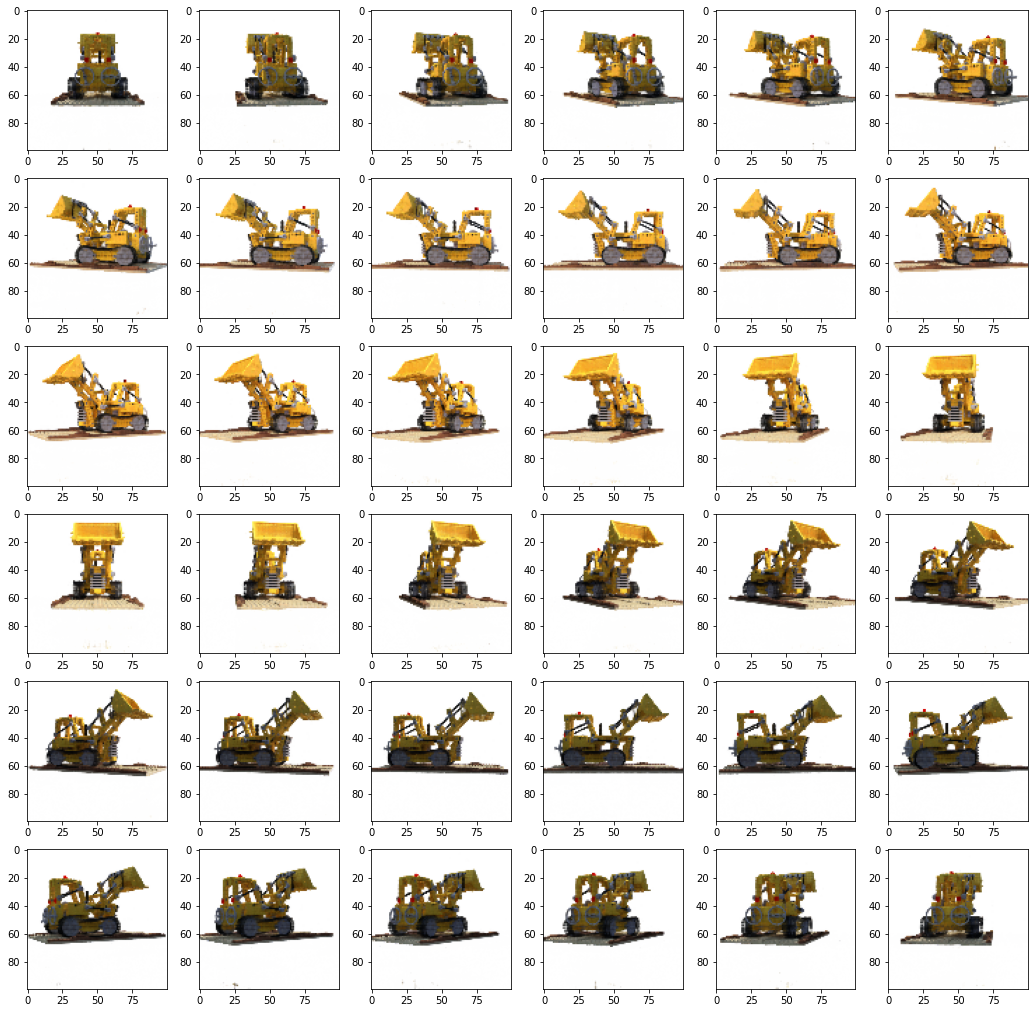

In [32]:
basedir = './logs'
expname = 'blender_paper_lego'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()

args = parser.parse_args('--config {}'.format(config))
args.n_gpus = torch.cuda.device_count()

# Create nerf model
_, render_kwargs_test, _, _, _ = run_nerf.create_nerf(args)

bds_dict = {
    'near' : 2.0,
    'far' : 6.0,
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly

H, W, focal = 800, 800, 1200.
down = 8
with torch.no_grad():
    fig = plt.figure(figsize=(18,18))
    axes = fig.subplots(nrows=6, ncols=6)
    for i in range (36):
        x = i//6; y = i%6
        c2w = load_blender.pose_spherical(i*10., 0., 4.)
        rgb, disp, _, _ = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3, :4], **render_kwargs_test)
        axes[x,y].imshow(rgb.cpu().numpy())
    plt.show()

### Query network on dense 3d grid of points

(257, 257, 257, 3)
(257, 257, 257, 4)


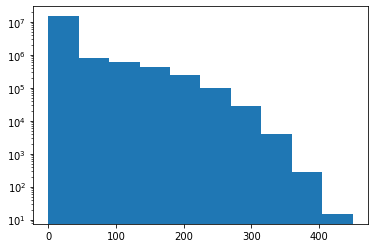

In [3]:
N = 256
t = np.linspace(-1.2, 1.2, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = torch.from_numpy(query_pts.reshape([-1,3]))


with torch.no_grad():
    fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:].to(device), viewdirs=torch.zeros_like(flat[i0:i1]).to(device), network_fn=render_kwargs_test['network_fine'])
    chunk = 1024*64
    raw = np.concatenate([fn(i, i+chunk).cpu().numpy() for i in range(0, flat.shape[0], chunk)], 0)
    raw = np.reshape(raw, list(sh[:-1]) + [-1])
    sigma = np.maximum(raw[...,-1], 0.)
    
    print(raw.shape)
    plt.hist(np.maximum(0,sigma.ravel()), log=True)
    plt.show()

### Marching cubes with [PyMCubes](https://github.com/pmneila/PyMCubes)
Change `threshold` to use a different sigma threshold for the isosurface

In [ ]:
import mcubes

threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

### Uncomment to save out the mesh
# mcubes.export_mesh(vertices, triangles, "logs/lego_example/lego_{}.dae".format(N), "lego")

### Live preview with [trimesh](https://github.com/mikedh/trimesh)
Click and drag to change viewpoint

In [ ]:
import trimesh

mesh = trimesh.Trimesh(vertices / N - .5, triangles)
mesh.show()

### Save out video with [pyrender](https://github.com/mmatl/pyrender)

In [ ]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import pyrender
from load_blender import pose_spherical

In [ ]:
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh, smooth=False))

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

camera_pose = load_blender.pose_spherical(-20., -40., 1.).cpu().numpy()
nc = pyrender.Node(camera=camera, matrix=camera_pose)
scene.add_node(nc)

# Set up the light -- a point light in the same spot as the camera
light = pyrender.PointLight(color=np.ones(3), intensity=4.0)
nl = pyrender.Node(light=light, matrix=camera_pose)
scene.add_node(nl)

# Render the scene
r = pyrender.OffscreenRenderer(640, 480)
color, depth = r.render(scene)

plt.imshow(color)
plt.show()
plt.imshow(depth)
plt.show()


In [ ]:
imgs = []
for th in np.linspace(0, 360., 120+1)[:-1]:
    camera_pose = pose_spherical(th, -40., 1.).cpu().numpy()
    scene.set_pose(nc, pose=camera_pose)
    imgs.append(r.render(scene)[0])
f = 'logs/blender_paper_lego/lego_mesh_turntable.mp4'
imageio.mimwrite(f, imgs, fps=30)
print('done')

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)